# Part 1: Building an Item-Item Recommender
If you use Netflix, you will notice that there is a section titled "Because you watched Movie X", which provides recommendations for movies based on a recent movie that you've watched. This is a classic example of an item-item recommendation.

In this tutorial, we will generate item-item recommendations using a technique called <a href="https://en.wikipedia.org/wiki/Collaborative_filtering">collaborative filtering</a>. Let's get started!

## Step 1: Import the Dependencies
We will be representing our data as a pandas DataFrame.

What is a DataFrame?

- a two-dimensional Pandas data structure
- columns represent features, rows represent items
- analogous to an Excel spreadsheet or SQL table
- documentation can be found here

We will also be using two plotting packages: matplotlib and seaborn (which is a wrapper of matplotlib) to visualize our data.

In [609]:
import pandas as pd
import numpy as np
import ast

## Step 2: Load the Data 

Let's download a small version of the MovieLens dataset. You can access it via the zip file url here, or directly download here. We're working with data in ml-latest-small.zip and will need to add the following files to our local directory:

- ratings.csv
- movies.csv
These are also located in the data folder inside this GitHub repository.

Alternatively, you can access the data here:

- https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv
- https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv

Let's load in our data and take a peek at the structure.

In [610]:
ratings = pd.read_csv("../data/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [611]:
ratings.shape

(100004, 4)

In [612]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [613]:
movies = pd.read_csv("../data/movies.csv")
movies.head()

,genres,id,original_title,popularity,release_date
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,Toy Story,21.946943,1995-10-30
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,Jumanji,17.015539,1995-12-15
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,Grumpier Old Men,11.7129,1995-12-22
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,Waiting to Exhale,3.859495,1995-12-22
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Father of the Bride Part II,8.387519,1995-02-10


In [614]:
movies.shape

(45466, 5)

In [615]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   genres          45466 non-null  object
 1   id              45466 non-null  object
 2   original_title  45466 non-null  object
 3   popularity      45461 non-null  object
 4   release_date    45379 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


## Step 3: Data pre-processing
In Part 1 of this tutorial series, we will focus on the `ratings` dataset. We'll need `movies` for subsequent sections. `Ratings` contains user's ratings for a given movie. Let's see how many ratings, unique movies, and unique users are in our dataset.

In [616]:
movies = (movies
          # Alternative : .drop(movies[~movies['id'].str.isnumeric()].index)
          .drop_duplicates(subset=['original_title'])
          .dropna()
          .astype({'id': np.int64})
         )
movies.head()

,genres,id,original_title,popularity,release_date
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,Toy Story,21.946943,1995-10-30
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,Jumanji,17.015539,1995-12-15
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,Grumpier Old Men,11.7129,1995-12-22
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,Waiting to Exhale,3.859495,1995-12-22
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Father of the Bride Part II,8.387519,1995-02-10


In [617]:
movie_genres = []
for line in movies['genres']:
    line = ast.literal_eval(line)
    list_comp = [element['name'] for element in line]
    movie_genres.append(list_comp)
    
movies['genres'] = movie_genres
movies.head()

,genres,id,original_title,popularity,release_date
0,"[Animation, Comedy, Family]",862,Toy Story,21.946943,1995-10-30
1,"[Adventure, Fantasy, Family]",8844,Jumanji,17.015539,1995-12-15
2,"[Romance, Comedy]",15602,Grumpier Old Men,11.7129,1995-12-22
3,"[Comedy, Drama, Romance]",31357,Waiting to Exhale,3.859495,1995-12-22
4,[Comedy],11862,Father of the Bride Part II,8.387519,1995-02-10


In [618]:
movies.shape

(43287, 5)

In [619]:
ratings = (ratings
           .join(movies.set_index('id')['original_title'], on='movieId')
           .dropna())
ratings.head()

,userId,movieId,rating,timestamp,original_title
10,1,1371,2.5,1260759135,Rocky III
11,1,1405,1.0,1260759203,Greed
13,1,2105,4.0,1260759139,American Pie
15,1,2193,2.0,1260759198,My Tutor
16,1,2294,2.0,1260759108,Jay and Silent Bob Strike Back


In [620]:
ratings.shape

(43322, 5)

## Step 3: Exploratory Data Analysis
In Part 1 of this tutorial series, we will focus on the `ratings` dataset. We'll need `movies` for subsequent sections. `Ratings` contains user's ratings for a given movie. Let's see how many ratings, unique movies, and unique users are in our dataset.

## Step 4: Transforming the data
We will be using a technique called <a href="https://en.wikipedia.org/wiki/Collaborative_filtering">collaborative filtering</a> to generate user recommendations. This technique is based on the assumption of "homophily" - similar users like similar things. Collaborative filtering is a type of unsupervised learning that makes predictions about the interests of a user by learning from the interests of a larger population.

The first step of collaborative filtering is to transform our data into a `user-item matrix` - also known as a "utility" matrix. In this matrix, rows represent users and columns represent items. The beauty of collaborative filtering is that it doesn't require any information about the users or items to generate recommendations.

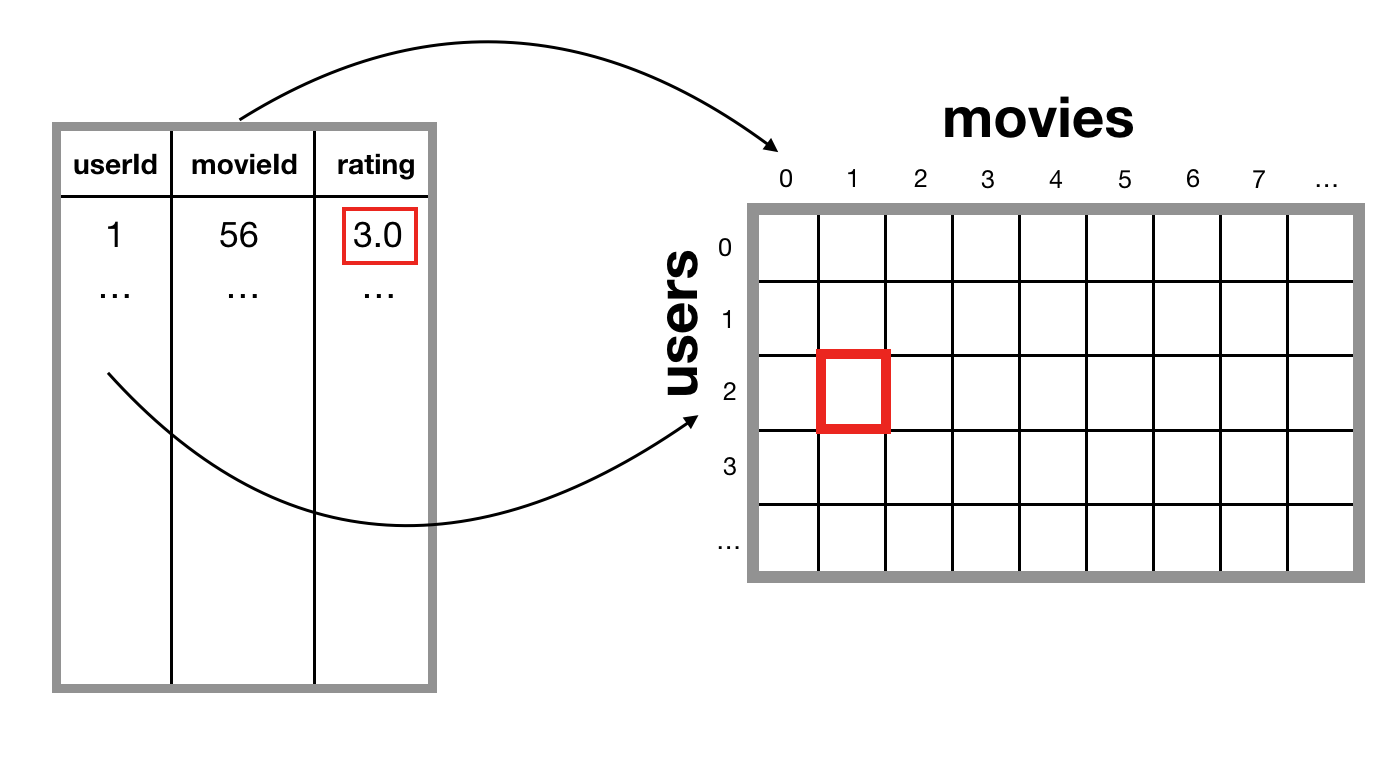

The create_X() function outputs a sparse matrix X with four mapper dictionaries:
- user_mapper: maps user id to user index
- movie_mapper: maps movie id to movie index
- user_inv_mapper: maps user index to user id
- movie_inv_mapper: maps movie index to movie id
We need these dictionaries because they map which row and column of the utility matrix corresponds to which user ID and movie ID, respectively.

The X (user-item) matrix is a scipy.sparse.csr_matrix which stores the data sparsely.

In [621]:
from scipy.sparse import csr_matrix
import time

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    start = time.time()
        
    N = df['userId'].nunique()
    M = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
    
    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))
    
    end = time.time()
    time_function = end - start
    
    
    return X, user_mapper, movie_mapper, time_function

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [ ]:
def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    start = time.time()
        
    N = df['userId'].nunique()
    M = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
    
    user_index = df['userId'].unique()
    movie_index = df['movieId'].unique()

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))
    
    end = time.time()
    time_function = end - start
    
    
    return X, user_mapper, movie_mapper, time_function

In [622]:
X, user_mapper, movie_mapper, time_function = create_X_2(ratings)

In [623]:
X

<2724x671 sparse matrix of type '<class 'numpy.float64'>'
	with 43322 stored elements in Compressed Sparse Row format>

In [624]:
time_function

0.12692475318908691

In [625]:
start = time.time()
b = (ratings
     .pivot(index='movieId', columns='userId', values='rating')
     .fillna(0))
end = time.time()
print(end-start)

0.08375072479248047


In [626]:
b

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,5.0,4.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [637]:
# Il faut faire la liaison avec les index ?

In [627]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Returns:
        list of k similar movie ID's
    """
#     movie_titles = dict(zip(ratings['movieId'], ratings['original_title']))
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    movie_vec = movie_vec.reshape(1,-1)
    
    k+=1

    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    
    neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
    neighbour_ids = [neighbour.item(i) for i in range(1, k)]
    
    return neighbour_ids

In [634]:
movie_titles = dict(zip(ratings['movieId'], ratings['original_title']))

movie_id = 455

similar_ids = find_similar_movies(movie_id, b, k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}")
for i in similar_ids:
    print(movie_titles[i])
    break

AttributeError: 'Series' object has no attribute 'reshape'

In [632]:
movie_titles

{1371: 'Rocky III',
 1405: 'Greed',
 2105: 'American Pie',
 2193: 'My Tutor',
 2294: 'Jay and Silent Bob Strike Back',
 2455: 'Vivement dimanche!',
 17: 'The Dark',
 62: '2001: A Space Odyssey',
 110: 'Trois couleurs : Rouge',
 144: 'Der Himmel über Berlin',
 150: '48 Hrs.',
 153: 'Lost in Translation',
 165: 'Back to the Future Part II',
 168: 'Star Trek IV: The Voyage Home',
 185: 'A Clockwork Orange',
 186: 'Lucky Number Slevin',
 222: 'Berlin: Die Sinfonie der Grosstadt',
 223: 'Rebecca',
 225: 'Czlowiek z zelaza',
 235: 'Stand by Me',
 248: 'Pocketful of Miracles',
 253: 'Live and Let Die',
 261: 'Cat on a Hot Tin Roof',
 265: 'Lili Marleen',
 266: 'Le Mépris',
 272: 'Batman Begins',
 273: 'Das weisse Rauschen',
 292: "Dave Chappelle's Block Party",
 296: 'Terminator 3: Rise of the Machines',
 300: 'La science des rêves',
 314: 'Catwoman',
 317: 'Grbavica',
 319: 'True Romance',
 339: 'Night on Earth',
 349: 'Crustacés et coquillages',
 350: 'The Devil Wears Prada',
 364: 'Batman 